In [1]:
import os, datetime
import numpy as np
import matplotlib.pyplot as plt

root_folder = os.path.join('..','..')

# Análisis de estacionalidad

En este notebook analizaremos estacionalidad a partir de la intuición y algunas técnicas descriptivas. Analizaremos los datos del Servicio Meteorológico Nacional del mes de Junio de 2022. 

Para este conjunto de datos no utilizaremos pandas por dos motivos: leer y filtrar datos suele ser más práctico con python puro y duro, por otro lado, pandas suele crear muchos objetos con memoria interna que en las notebooks de python llevan a errores muy comunes de reutilización de variables y tipos de datos

In [2]:
# Los datos del SMN tienen dos columnas de encabezado, hay que leer con cuidado, 
# parece estar hecho en un encoding traido de windows.
# Los archivos parecen tener ancho de columnas fijas
def read_fixed_columns_file(filename, widths, n_heads):
    '''
    Se deben proveer las posiciones de comienzo de las diferentes columnas, salvo la ultima
    Por ejemplo: para un archivo con dos columnas cuyos anchos sean 5 caracteres y 10
                widths = [0,5]
    n_heads: Numero de lineas de encabezado
    '''
    assert type(widths) == type([])
    with open(filename, 'rb') as fp:
        headers = []
        for i in range(n_heads):
            headers.append(next(fp).decode(errors='replace').split()) # elimino errores de codificación
        raw_data = []
        for line in fp:
            lines = line.decode(errors='replace')

            raw_data.append(
                [lines[widths[i]:widths[i+1]].strip() for i in range(len(widths)-1)]
                )
    return headers, raw_data

def clean_raw(raw_data):
    '''
    Como los archivos tienen varios problemas, esta función va desarrollandose a medida que
    tales problemas aparecen. Por ahora se observa que existen saltos de carro en algunas lineas
    de los archivos de texto
    '''
    # limpiando las columnas con salto de carro
    clean = []
    for l in raw_data:
        if l[0] != '':
            clean.append(l)
    # reemplazando los strings vacíos por -1 
    for l in range(len(clean)):
        for it in range(len(clean[l])):
            if clean[l][it] == '':
                clean[l][it] = '-1' # Controlando los datos vacíos

    return clean

In [3]:
data_folder = os.path.join(root_folder, 'Data', 'junio-SMN','horario')
# Leemos toda la carpeta
raw_data = []
for f in os.listdir(data_folder):
    headers, data = read_fixed_columns_file(os.path.join(data_folder, f),
                        widths=[0,8,14,20,25,33,38,43,1000],
                        n_heads=2)
    raw_data.append(clean_raw(data))

Cuando se tiene la lista de todos los datos recolectados, se pueden comenzar a convertir los datos a formatos que permitan su manipulación más simple.

En este caso vamos a poner todas los datos a continuación del otro en una lista de diccionarios para hacer las búsquedas más simples

In [4]:
data_fmttd = []
for day in raw_data:
    for d in day:
        # Since data is not very well structured and a lot of carriage return appear
        if len(d) > 7:
            data_fmttd.append({
                'timestamp': datetime.datetime.strptime(d[0],'%d%m%Y')+ datetime.timedelta(hours= int(d[1])),
                'temp': float(d[2]),
                'hum': float(d[3]),
                'pres': float(d[4]),
                'v_direcc': float(d[5])%360, # modulo function to put data into one cycle
                'v_intens': float(d[6]),
                'estac': d[7]
            }
            )
# Imprimimos un dato de ejemplo y sacamos los labels
labels = []
for k,v in data_fmttd[123].items():
    print(f'{k}: {v}')
    labels.append(k)
labels = labels[1:-1] # no necesitamos los timestamps ni la estacion

timestamp: 2023-06-30 05:00:00
temp: -12.6
hum: 89.0
pres: 1011.1
v_direcc: 200.0
v_intens: 30.0
estac: BASE MARAMBIO


## Filtrando los datos de Salta

Para analizar los datos de la estación que tiene Salta, podemos previsualizar los archivos para saber cómo se llama la estación, o simplemete buscar un substring dentro del elemento con clave que contiene SALTA

In [5]:
time_salta = []
data_salta = []
for element in data_fmttd:
    if element['estac'].find('SALTA') >= 0:
        time_salta.append(element['timestamp'])
        data_salta.append([
            element['temp'], 
            element['hum'], 
            element['pres'], 
            element['v_direcc'], 
            element['v_intens']])
# hacemos arrays de numpy con las listas y las ordenamos en el tiempo
time_salta = np.array(time_salta)
idx_sorted = np.argsort(time_salta)
time_salta = time_salta[idx_sorted]
data_salta = np.array(data_salta)[idx_sorted]

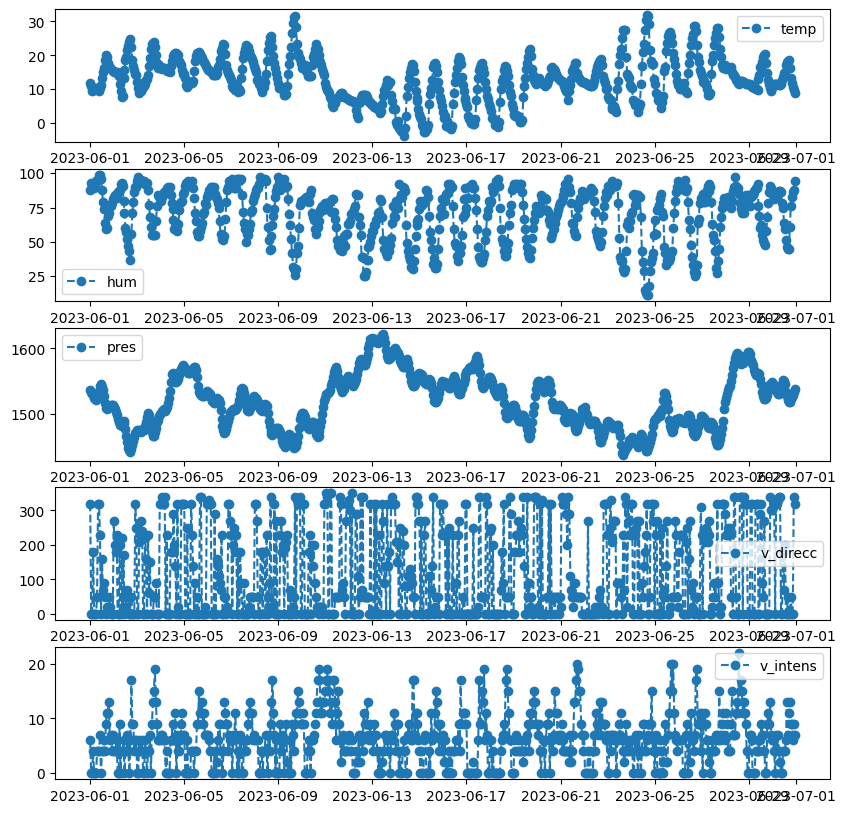

In [6]:
fig, axs = plt.subplots(data_salta.shape[1],1, figsize=(10,10))
for i in range(data_salta.shape[1]):
    axs[i].plot(time_salta, data_salta[:,i],'o--', label=labels[i])
    axs[i].legend()

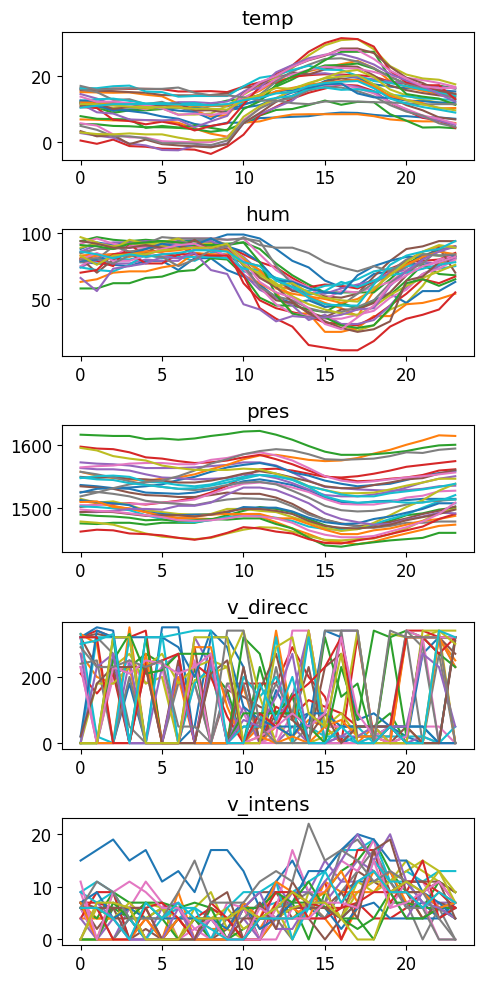

In [7]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(5,1, figsize=(5,10))
for i in range(len(labels)):
    for j in range(len(time_salta)//24):
        axs[i].plot(data_salta[j*24:(j+1)*24,i], '-')
    axs[i].set_title(labels[i])
fig.tight_layout()
plt.show()

In [8]:
# podemos extraer la media para cada hora durante los períodos de estacionalidad (los días)
# usando  slicin podemos aprovechar para extraer cada hora particular, por ejemplo observemos
# los timestams para los primeros 100 datos comenzando desde el 3
print(time_salta[3:100:24].astype(str)) # el truquito de "astype" de los arrays de numpy

['2023-06-01 03:00:00' '2023-06-02 03:00:00' '2023-06-03 03:00:00'
 '2023-06-04 03:00:00' '2023-06-05 03:00:00']


In [9]:
seasonal_salta = []
for i in range(24):
    seasonal_salta.append(data_salta[i::24])
seasonal_salta = np.array(seasonal_salta)
print(seasonal_salta.shape) # agrupamos en un array de tres dimensiones 

(24, 30, 5)


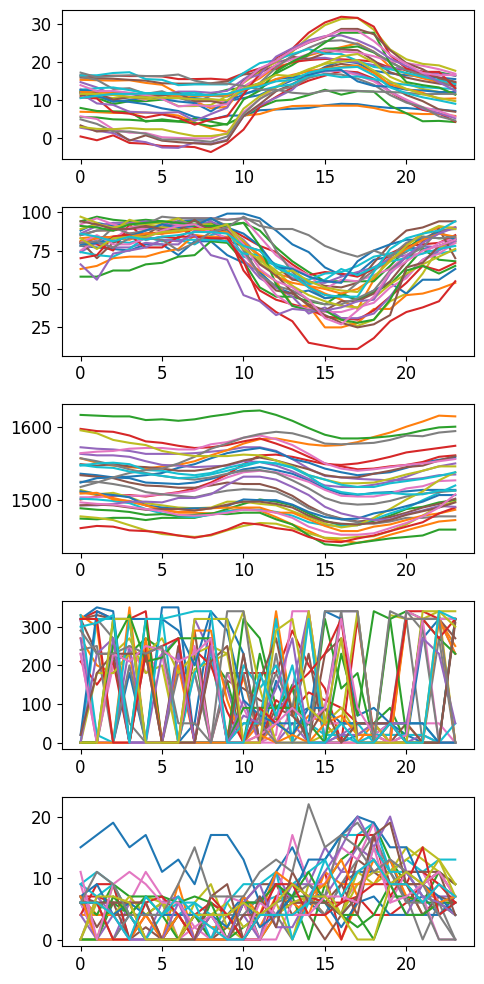

In [10]:
#reproducimos el grafico anterior para entender que hicimos
fig, axs = plt.subplots(5,1, figsize=(5,10))
for i in range(len(labels)):
    axs[i].plot(seasonal_salta[:,:,i])
fig.tight_layout()
plt.show()

In [11]:
# calculamos la media y la desviacion estandar para cada hora sobre los 30 días

seasonal_salta_media = seasonal_salta.mean(axis=1)
seasonal_salta_std = seasonal_salta.std(axis=1)
print(seasonal_salta_media.shape) # veamos que las dimensiones coinciden con lo buscado

(24, 5)


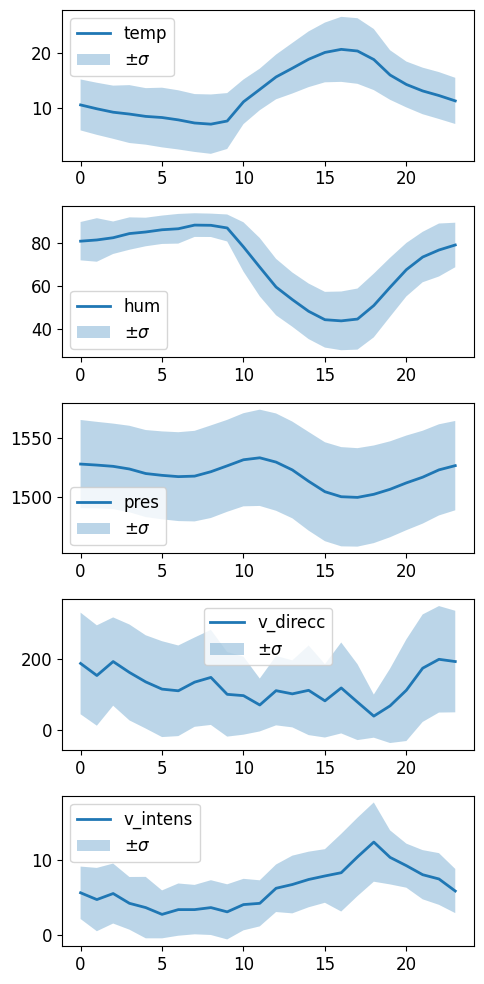

In [12]:
# haciendo un dibujito lindo e intuitivo

#reproducimos el grafico anterior para entender que hicimos
fig, axs = plt.subplots(5,1, figsize=(5,10))
for i in range(len(labels)):
    axs[i].plot(seasonal_salta_media[:,i], label=labels[i], lw = 2)
    down = seasonal_salta_media[:,i] - seasonal_salta_std[:,i]
    up = seasonal_salta_media[:,i] + seasonal_salta_std[:,i]
    axs[i].fill_between(np.arange(24),down, up, label='$\pm \sigma$', alpha = 0.3)
    axs[i].legend()
fig.tight_layout()
plt.show()

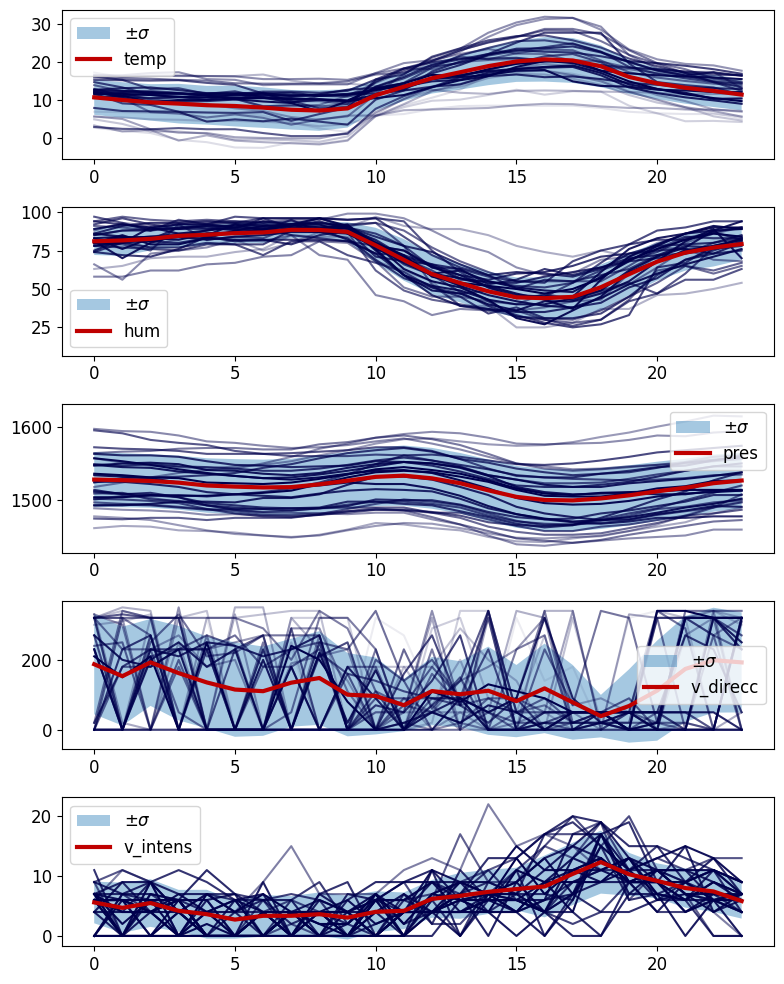

In [13]:
# mejorando el dibujito para impresionar en el informe

# Podemos ponerle intensidad de colores a cada día según más o menos cerca se encuentre de la media,
# para ello asignamos un coeficiente (el MAE) de todo un día respecto de la media 

def mae(y, y_hat):
    return np.abs(y-y_hat).mean(axis = 0)

# para cada día calculamos el mae
mae_coef = []
for i in range(30):
    mae_coef.append(mae(seasonal_salta[:,i,:], seasonal_salta_media))
mae_coef = (np.array(mae_coef)-np.min(mae_coef, axis=0) )/(np.max(mae_coef, axis=0)-np.min(mae_coef, axis=0)) # normalizamos los coeficientes


#reproducimos el grafico anterior para entender que hicimos
fig, axs = plt.subplots(5,1, figsize=(8,10))
for i in range(len(labels)):

    down = seasonal_salta_media[:,i] - seasonal_salta_std[:,i]
    up = seasonal_salta_media[:,i] + seasonal_salta_std[:,i]
    axs[i].fill_between(np.arange(24),down, up, label='$\pm \sigma$', alpha = 0.4)
    for j in range(30):
        axs[i].plot(seasonal_salta[:,j,i], color = (0,0,0.3), alpha = 1-mae_coef[j,i] )
    axs[i].plot(seasonal_salta_media[:,i], color = (0.75,0,0), label=labels[i], lw = 3)

    axs[i].legend()
fig.tight_layout()
plt.show()

Los gráficos anteriores fueron útiles para comprender cual es la dispersión de datos respecto de un intervalo estacional, así se ve que dentro de una desviación estándar, salvo el caso de la dirección del viento las otras series temporales parecen tener una componente estacional bien marcada. También en este tipo de gráficos se puede observar que existen ciertos días anómalos, o que se apartan del grueso de los datos. Detectar las anomalías es una de las tareas cruciales del análisis de series temporales. Ahora bien, para entender si existe una tendencia, se debe analizar alguna otra característica desarrollada en el tiempo, como se muestra a continuación.

# Estimación de la tendencia

Como se ha visto en el apartado previo, la media móvil puede ser de gran utilidad para suavizar las series temporales. Aquí trabajaremos sólo con la temperatura para no abundar y explicar los conceptos

Como primera medida observaremos el efecto del ancho de la ventana sobre la media móvil

In [14]:
def ma(t, x, ws= 5):
    ''' Funcion para calcular la media movil de una serie temporal (simetrica)
        Entradas:
            - t: timestamps
            - x: serie datos
            - ws: tamaño de la ventana
        Salidas:
            - t: timestamps
            - y: media movil
    '''

    assert ws%2 == 1, 'ws debe ser entero e impar' 
    n_samples = x.shape[0]
    n_windows = n_samples-ws
    tstamps = []
    y = np.zeros(n_windows)
    for i in range(0, n_windows):
        right = n_samples - i 
        left = n_samples - i - ws 
        y[n_windows - i - 1] = x[left:right].mean() 
        tstamps.insert(0,t[(left+right)//2])
    return tstamps, y

def mstd(t, x, ws= 5):
    ''' Funcion para calcular la media movil de una serie temporal (simetrica)
        Entradas:
            - t: timestamps
            - x: serie datos
            - ws: tamaño de la ventana
        Salidas:
            - t: timestamps
            - y: media movil
    '''

    assert ws%2 == 1, 'ws debe ser entero e impar' 
    n_samples = x.shape[0]
    n_windows = n_samples-ws
    tstamps = []
    y = np.zeros(n_windows)
    for i in range(0, n_windows):
        right = n_samples - i 
        left = n_samples - i - ws 
        y[n_windows - i - 1] = x[left:right].std() 
        tstamps.insert(0,t[(left+right)//2])
    return tstamps, y

In [15]:
data_salta_temp = data_salta[:,0]
ts = []
medias = []
wsizes = [1,5,12,15,20]
for i in wsizes:
    ts_aux, m_aux = ma(time_salta, data_salta_temp, ws = 2*i+1)
    ts.append(ts_aux)
    medias.append(m_aux)

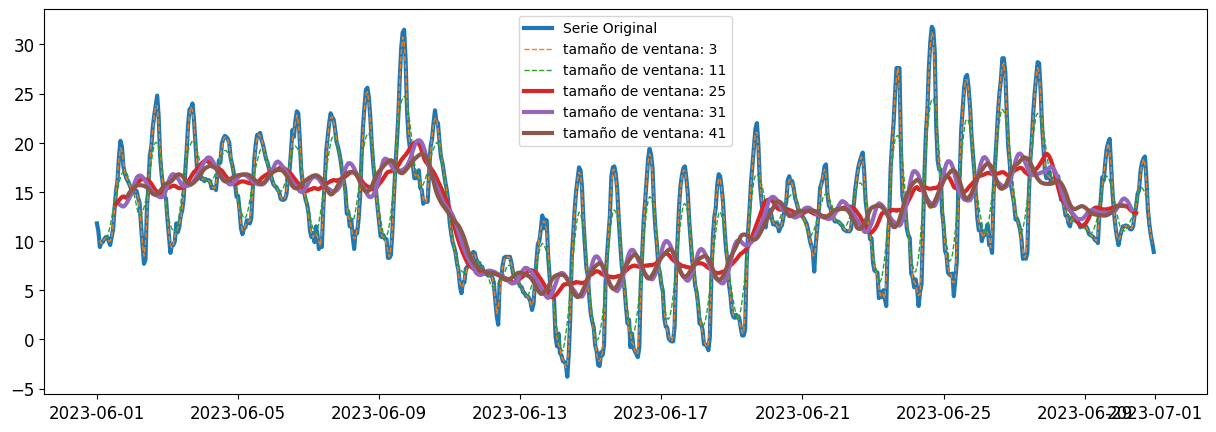

In [16]:
plt.figure(figsize=(15,5))
plt.plot(time_salta, data_salta_temp, label = 'Serie Original', lw = 3)
count = 0
for i in wsizes:
    llw = 1
    ls = 'dashed'
    if i >= 12:
        llw = 3
        ls = 'solid'
    plt.plot(ts[count], medias[count], lw = llw, linestyle= ls,label = f'tamaño de ventana: {2*i+1}')
    count+=1
plt.legend(fontsize = 10)

para los diferentes valores de ventanas de la media móvil, se puede ver que una media de 25 horas, el suavizado es mayor. A partir de esta tendencia, se pueden realizar predicciones para tiempos futuros. También se pueden hacer ajustes funcionales para tener expresiones analíticas. 

Resulta importante observar si la dispersión de los datos es aditiva o multiplicativa. Para ello utilizaremos la desviación estándar de los datos en ventanas móviles, de modo que se pueda observar su variación en el tiempo. Utilizaremos una ventana de 25 horas, ya que muestra la tendencia de modo más suave

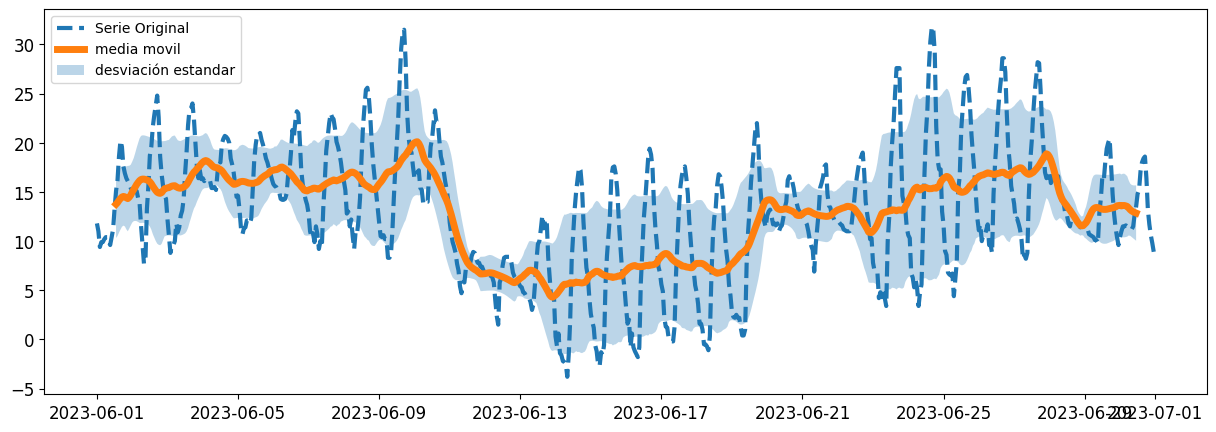

In [17]:
ts_25, m_25 = ma(time_salta, data_salta_temp, ws = 25)
ts_25, std_25 = mstd(time_salta, data_salta_temp, ws = 25)

plt.figure(figsize=(15,5))
plt.plot(time_salta, data_salta_temp, linestyle = 'dashed', label = 'Serie Original', lw = 3)
plt.plot(ts_25, m_25, lw = 5, linestyle= 'solid', label = f'media movil')
plt.fill_between(ts_25, m_25-std_25, m_25+std_25, alpha = 0.3, label = 'desviación estandar')
plt.legend(fontsize = 10)
plt.show()

En el gráfico anterior se observa que si bien hay variaciones, la desviación estándar no muestra una tendencia clara de crecimiento/decrecimiento en el tiempo. Esto lleva a pensar que la serie se puede escribir como:
$$X(t) = m_t + S_t + \varepsilon_t,$$
donde $m_t$ será la tendencia, $S_t$ será la oscilación estacional y $\varepsilon_t$ un ruido estocástico

# Correlaciones y Autocorrelacion

Entendiendo las distribucioneas aleatorias, la correlación y la autocorrelación

In [19]:
rands = np.random.default_rng()
x = rands.normal(0, 1, size=100) # distribución normal con media 0, y sigma =1
y = rands.normal(0, 1, size=200)
x_hat = x.mean()
y_hat = y.mean()
print(f'X media: {x_hat}, X sigma: {x.std()}')
print(f'Y media: {y_hat}, Y sigma: {y.std()}')

X media: 0.14831922016558477, X sigma: 0.9004328885807026
Y media: -0.07836832909537937, Y sigma: 0.9247015039075217


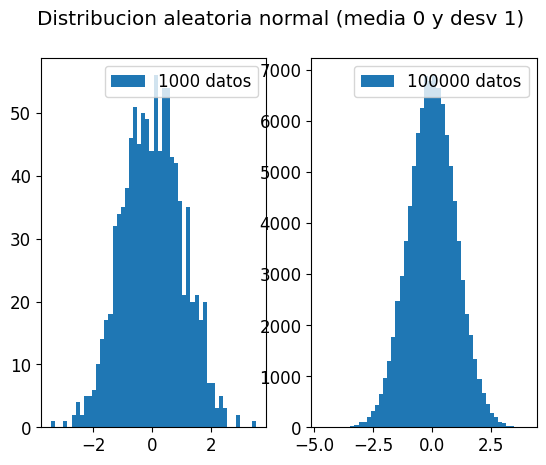

In [20]:
# las distribuciones se generan  de modo que la media y la desviacion estandar sea la prefijada
# en infinitos sorteos 
fig, axs = plt.subplots(1,2)
fig.suptitle('Distribucion aleatoria normal (media 0 y desv 1)') 
axs[0].hist(rands.normal(0, 1, 1000), 50, label='1000 datos')
axs[0].legend()
axs[1].hist(rands.normal(0, 1, 100000), 50, label='100000 datos')
axs[1].legend()
plt.show()

Text(0, 0.5, 'media')

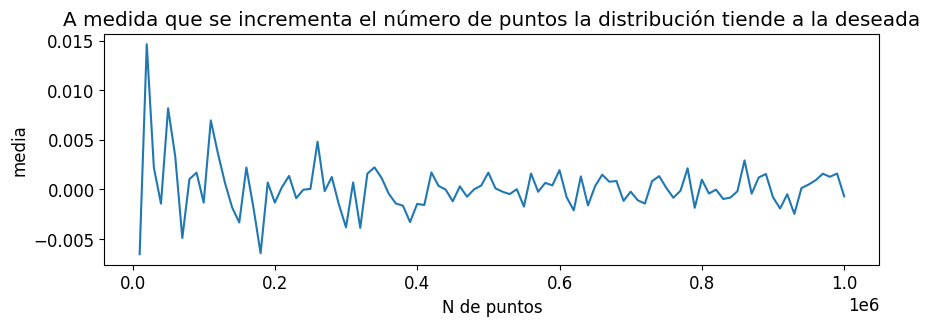

In [21]:
# Estudiemos la media a medida que incrementamos el numero de datos en la distribución
tamanios = (np.arange(100)+1)*10000
medias = [rands.normal(0,1, t). mean() for t in tamanios]
plt.figure(figsize=(10,3))
plt.title('A medida que se incrementa el número de puntos la distribución tiende a la deseada')
plt.plot(tamanios, medias)
plt.xlabel('N de puntos')
plt.ylabel('media')

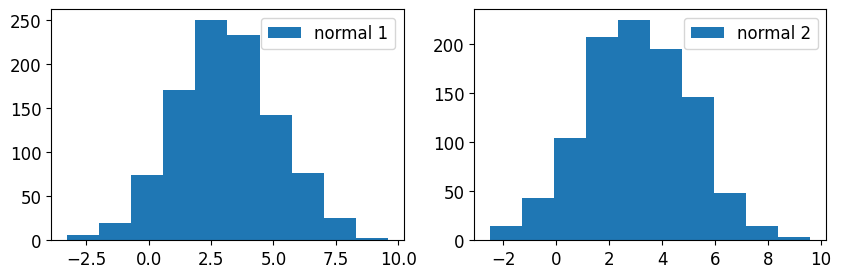

In [22]:
# Tomando dos distribuciones
x = rands.normal(3,2, size = 1000)
y = rands.normal(3,2,1000)
fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(x,10, label='normal 1')
axs[0].legend()
axs[1].hist(y,10, label= 'normal 2')
axs[1].legend()

In [23]:
print(f'La cantidad sum(x-x.mean()) es nula: {np.sum(x-x.mean())}')
print(f'La cantidad sum(y-y.mean()) es nula: {np.sum(y-y.mean())}')
print(f'La cantidad sum((x-x.mean())(y-y.mean())) no es nula: {np.sum((x-x.mean())**2)}')
print(f'La cantidad sum((x-x.mean())(y-y.mean())) no es nula: {np.sum((x-x.mean())*(y-y.mean()))}')

La cantidad sum(x-x.mean()) es nula: 2.149391775674303e-13
La cantidad sum(y-y.mean()) es nula: 2.842170943040401e-14
La cantidad sum((x-x.mean())(y-y.mean())) no es nula: 3969.277000896388
La cantidad sum((x-x.mean())(y-y.mean())) no es nula: -112.29382736263159


In [24]:
def correl(x, y):
    xm = x.mean()
    ym = y.mean()
    denom = np.sqrt(np.sum((x-xm)**2) * np.sum((y-ym)**2))
    return np.sum((x-xm)*(y-ym))/denom

In [25]:
print(f'La correlacion (x, y): {correl(x,y)}')
print(f'La correlacion (y, x): {correl(y,x)}')
print(f'La correlacion (x, x): {correl(x,x)}')
print(f'La correlacion (y, y): {correl(x,x)}')

La correlacion (x, y): -0.028451151540815577
La correlacion (y, x): -0.028451151540815577
La correlacion (x, x): 1.0
La correlacion (y, y): 1.0


¿Por qué las correlaciones entre dos distribuciones normales similares es muy pequeña? 

Para comprender en mayor profundidad la correlación, dibujemos punto por punto ambas series 

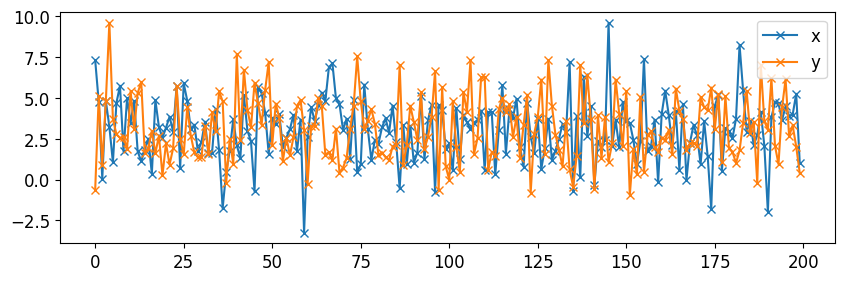

In [26]:
plt.figure(figsize=(10,3))
plt.plot(x[:200], 'x-',label = 'x')
plt.plot(y[:200], 'x-',label = 'y')
plt.legend()

Las series no se parecen en nada punto por punto
Para inspeccionar con mayor profundidad esta función simulemos una serie con estacionalidad mas un ruido aleatorio

La correlación es: 0.980939577686694


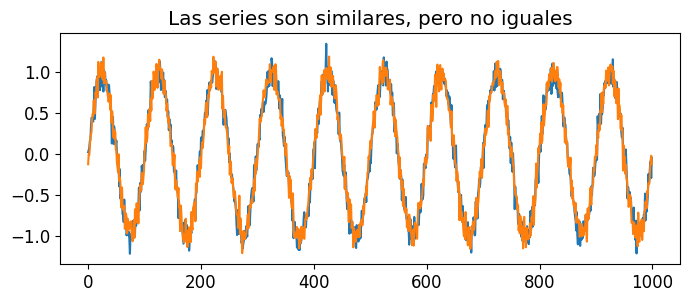

In [27]:
n = 1000
f = 1/100
t = np.arange(n)
fase = 0
x = np.sin(2*np.pi*f*t)+ rands.normal(0,0.1,n) # ruido aditivo
y = np.sin(2*np.pi*f*t + fase)+ rands.normal(0,0.1,n) # ruido aditivo
plt.figure(figsize=(8,3))
plt.plot(t,x)
plt.plot(t,y)
plt.title(f'Las series son similares, pero no iguales')
print(f'La correlación es: {correl(x,y)}')

Estudiemos la correlación en función del ruido

Text(0, 0.5, 'correlacion')

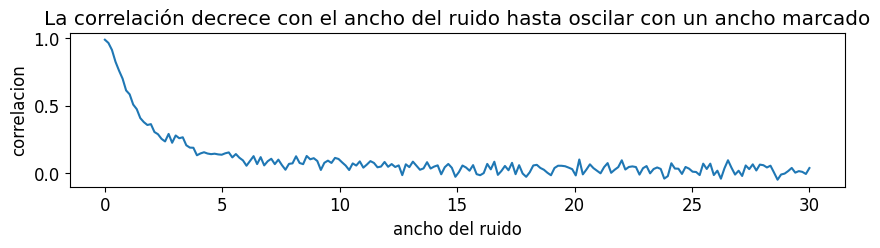

In [28]:
corrs = []
noises = np.linspace(0,30, 200)
for noise in noises:
    y = np.sin(2*np.pi*f*t + fase)+ rands.normal(0,noise,n) # ruido aditivo
    corrs.append(correl(x,y))
plt.figure(figsize=(10,2))
plt.title('La correlación decrece con el ancho del ruido hasta oscilar con un ancho marcado')
plt.plot(noises, corrs)
plt.xlabel('ancho del ruido')
plt.ylabel('correlacion')

El ancho de la oscilación está relacionada con que hay una componente oscilatoria idéntica para ambas distribuciones.

También se puede estudiar el efecto del defasaje

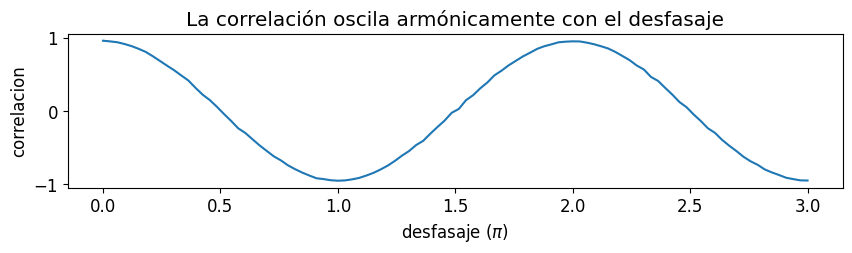

In [29]:
corrs = []
fases = np.linspace(0,3*np.pi, 100)
for fase in fases:
    y = np.sin(2*np.pi*f*t + fase)+ rands.normal(0,0.2,n) # ruido aditivo
    corrs.append(correl(x,y))
plt.figure(figsize=(10,2))
plt.title('La correlación oscila armónicamente con el desfasaje')
plt.plot(fases/np.pi, corrs)
plt.xlabel('desfasaje ($\pi$)')
plt.ylabel('correlacion')
plt.show()

Se ve claramente que cuando el desfasaje es $\pi$, la correlacion es maxima y negativa. Esto significa que las series están en oposición de fase, y luego en $2\pi$ la correlación es máxima, ambas distribuciones están en fase.

Analicemos cómo se correlacionan las temperatura y la humedad en junio de 2023 en Salta, que a simple vista parecen estar correlacionadas

Text(0.5, 1.0, 'La correlacion es: -0.5564757684659261')

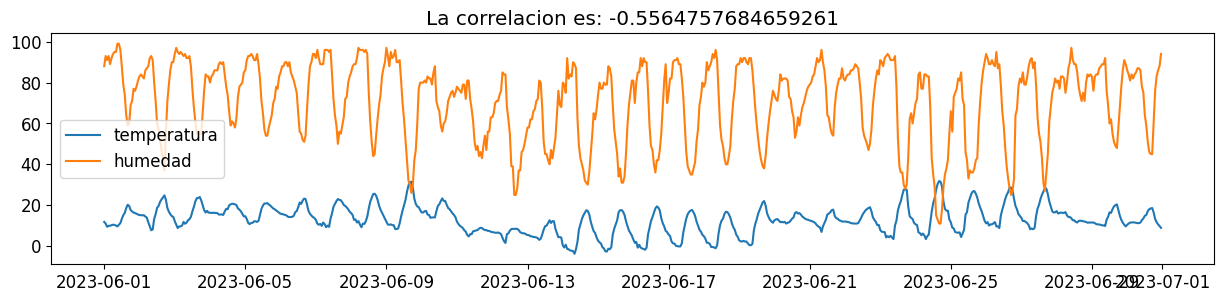

In [30]:
data_salta_hum = data_salta[:,1]
plt.figure(figsize=(15,3))
plt.plot(time_salta, data_salta_temp, label='temperatura')
plt.plot(time_salta, data_salta_hum, label='humedad')
plt.legend()
plt.title(f'La correlacion es: {correl(data_salta_hum, data_salta_temp)}')

Como la correlación es negativa, las series están en oposición de fase. Ahora podemos examinar el concepto de autocorrelación

Para una serie univariada, podemos ver cómo se correlaciona consigo misma en diferentes instantes de tiempo. Trabajemos con la temperatura

Text(0, 0.5, 'Autocorrelacion')

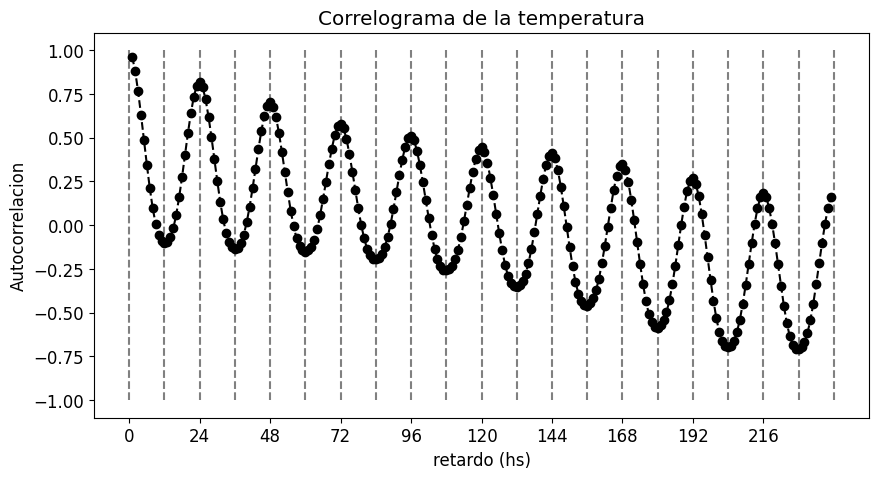

In [48]:
lookback = 240
corrs = []
for n in range(1,lookback):
    corrs.append(correl(data_salta_temp[n:], data_salta_temp[:-n]))
plt.figure(figsize=(10,5))
plt.title('Correlograma de la temperatura')
plt.vlines([12*i for i in range(21)],-1,1, colors='gray', linestyles='dashed')
plt.plot(np.arange(lookback-1)+1, corrs, 'ko--')
plt.xticks([24*i for i in range(10)])
plt.xlabel('retardo (hs)')
plt.ylabel('Autocorrelacion')

El correlograma expone la periodicidad de manera evidente.



# Convolución - Filtrados

Otra técnica que puede ser muy útil a la hora de analizar series temporales está relacionada con el filtrado de las señales a partir de convoluciones con ciertas plantillas